In [ ]:
#! /usr/bin/python
# -*- coding: utf-8 -*-
# @author izhangxm
# Copyright 2017 izhangxm@gmail.com. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from itertools import product
import os.path as osp
from scipy.optimize import leastsq
import time
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import math
# from tqdm import tqdm, trange
from tqdm.notebook import  tqdm

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [2]:
class MyDataset(object):

    def __init__(self, dataset_path):

        self.dataset_path = dataset_path

        df = pd.read_csv(dataset_path)
        # 数据初步处理
        # 计算反应速率rate，初始速率固定设置为0

        for c_i, (col_name, col_sr) in enumerate(df.items()):
            if "error" in col_name or "time" in col_name or "rate" in col_name:
                continue
            rate_col_name = f"{col_name}_rate"
            rates = []
            pre_t = None
            pre_v = None
            for th, (index, value) in zip(df['time'], col_sr.items()):
                if int(index) == 0:
                    rates.append(0.0)
                    pre_t = th
                    pre_v = value
                    continue

                delta_t = th - pre_t
                delta_value = value - pre_v
                # print(col_name, index, pre_t, th, pre_v ,value)
                rates.append(delta_value / delta_t)
                pre_t = th
                pre_v = value
            df[rate_col_name] = rates

        self.df = df
        # 准备输出值 Y
        self.cct_names = []
        for x in self.df.columns:
            if "time" in x or "error" in x or "rate" in x:
                continue
            self.cct_names.append(x)
        self.rates_names = [f"{x}_rate" for x in self.cct_names]
        self.error_names = [f"{x}-error" for x in self.cct_names]

        self.cct = self.df[self.cct_names].values
        self.rates = self.df[self.rates_names].values
        self.errors = self.df[self.error_names].values

    def get_rates(self):
        return self.rates

    def get_df(self):
        return self.df

    def get_errors(self):
        return self.errors

    def get_cct(self):
        return self.cct

    def get_var_col_names(self):
        return self.cct_names, self.rates_names, self.error_names

    def get_weights(self):
        max_value = self.df[self.cct_names].describe().loc['max'].values.max()

        vars_max = self.df[self.cct_names].describe().loc['max']
        weights = (max_value / vars_max).values

        return np.array(weights)

    def get_vars_max(self):
        vars_max = self.df[self.cct_names].describe().loc['max'].values
        return vars_max



In [3]:
def get_target(ks, df, k_kinetics):
    def _swt_k_kinetics(k_i, sr_vs):
        kk = k_kinetics[k_i]
        k = ks[k_i]
        if kk == 0:
            return kk
        elif kk == 1:
            return k * sr_v
        elif kk == 2:
            return k * sr_v ** 2
        raise Exception(f"unknown kinetics:{kk}")

    target = []  # 'xNH3', 'xNO3', 'xNO2', 'xNOrg', 'xN2', 'ANH3', 'ANO3', 'ANO2', 'ANOrg', 'AN2'
    for i in range(0, len(df)):
        sr = df.iloc[i]

        r1 = ks[0] * sr['xN2'] if k_kinetics[0] == 1 else ks[0]
        r2 = ks[1] * sr['xNH3'] if k_kinetics[1] == 1 else ks[1]
        r3 = ks[2] * sr['xNO2'] if k_kinetics[2] == 1 else ks[2]
        r4 = ks[3] * sr['xNO3'] if k_kinetics[3] == 1 else ks[3]
        r5 = ks[4] * sr['xNO2'] if k_kinetics[4] == 1 else ks[4]
        r6 = ks[5] * sr['xNO2'] * sr['xNO3'] if k_kinetics[5] == 1 else ks[5]
        r7 = ks[6] * sr['xNO3'] if k_kinetics[6] == 1 else ks[6]
        r8 = ks[7] * sr['xNO3'] if k_kinetics[7] == 1 else ks[7]
        r9 = ks[8] * sr['xNH3'] if k_kinetics[8] == 1 else ks[8]
        r10 = ks[9] * sr['xNOrg'] if k_kinetics[9] == 1 else ks[9]
        r11 = ks[10] * sr['xNOrg'] if k_kinetics[10] == 1 else ks[10]

        xNH3_rate = 2 * r1 + r7 + r10 - r2 - r6 - r9
        xNO3_rate = r3 - r7 - r4 - r8 + r11
        xNO2_rate = r2 + r4 - r3 - r6 - 2 * r5
        xNOrg_rate = r8 + r9 - r10 - r11
        xN2_rate = r5 + r6 - r1
        ANH3_rate = (2 * r1 * (sr['AN2'] - sr['ANH3']) + (sr['ANO3'] - sr['ANH3']) * r7 + (
                    sr['ANOrg'] - sr['ANH3']) * r10) / sr['xNH3']
        ANO3_rate = ((sr['ANO2'] - sr['ANO3']) * r2 + (sr['ANOrg'] - sr['ANO3']) * r11) / sr['xNO3']
        ANO2_rate = ((sr['ANH3'] - sr['ANO2']) * r2 + (sr['ANO3'] - sr['ANO2']) * r4) / sr['xNO2']
        ANOrg_rate = ((sr['ANO3'] - sr['ANOrg']) * r8 + (sr['ANH3'] - sr['ANOrg']) * r9) / sr['xNOrg']
        AN2_rate = ((sr['ANO2'] - sr['AN2']) * r5 + (sr['ANO2'] * sr['ANH3'] - sr['AN2']) * r6) / sr['xN2']

        line_rate = [xNH3_rate, xNO3_rate, xNO2_rate, xNOrg_rate, xN2_rate, ANH3_rate, ANO3_rate, ANO2_rate, ANOrg_rate,
                     AN2_rate]
        target.append(line_rate)
    target = np.array(target)
    return target


In [4]:
def r2_loss(pred, y):
    r2_loss = 1 - np.square(pred - y).sum() / np.square(y - np.mean(y)).sum()
    return r2_loss


def get_model(dataset, k_kinetics, k_sigma_priors=0.1, kf_type=0):
    # 定义参数优化模型
    mcmc_model = pm.Model()
    ## 参数个数
    params_n = 11

    ks = []
    with mcmc_model:
        for ki in range(1, params_n + 1):
            if kf_type == 0:
                p_dense = pm.HalfNormal(f"k{ki}", sigma=k_sigma_priors)
            else:
                p_dense = pm.Normal(f"k{ki}", mu=0, sigma=k_sigma_priors)
            ks.append(p_dense)

    df = dataset.get_df()
    errors = dataset.get_errors()
    rates = dataset.get_rates()

    target = get_target(ks, df, k_kinetics)
    target = np.array(target)[1:].reshape(-1).tolist()
    sigma_Y = errors[1:].reshape(-1).tolist()
    rata_Y = rates[1:].reshape(-1).tolist()

    with mcmc_model:
        sigma = pm.HalfCauchy('sigma', beta=10, initval=0.1)
        y_obs = pm.Normal(f"rates", mu=target, sigma=sigma, observed=rata_Y, shape=len(rata_Y))

    return mcmc_model


In [5]:
def get_predict_ks(idata):
    parames_summary = az.summary(idata, round_to=10)
    ks_names = [f"k{x + 1}" for x in range(11)]

    predict_ks = []
    for k_name in ks_names:
        k_v = parames_summary["mean"][k_name]
        predict_ks.append(k_v)
    return np.array(predict_ks)

In [6]:
def opt_model(dataset, k_kinetics, k_sigma_priors=0.01, kf_type=0, draws=10000, tune=2000, chains=4, cores=4):
    mcmc_model = get_model(dataset, k_kinetics, k_sigma_priors=k_sigma_priors, kf_type=kf_type)
    idata = pm.sample(draws=draws, model=mcmc_model, chains=chains, cores=cores, tune=tune)
    return idata


def eval_model(idata, dataset):
    predict_ks = get_predict_ks(idata)
    predict = get_target(predict_ks, df, k_kinetics)
    rates_y = dataset.get_rates()
    r2 = r2_loss(predict[1:], rates_y[1:])
    return r2


In [7]:
def dcdt_func(t, c, ks, k_kinetics, switch_tc=False):

    if switch_tc:
        _a = t
        t = c
        c = _a

    c_xNH3, c_xNO3, c_xNO2, c_xNOrg, c_xN2, c_ANH3, c_ANO3, c_ANO2, c_ANOrg, c_AN2 = c

    r1 = ks[0] * c_xN2 if k_kinetics[0] == 1 else ks[0]
    r2 = ks[1] * c_xNH3 if k_kinetics[1] == 1 else ks[1]
    r3 = ks[2] * c_xNO2 if k_kinetics[2] == 1 else ks[2]
    r4 = ks[3] * c_xNO3 if k_kinetics[3] == 1 else ks[3]
    r5 = ks[4] * c_xNO2 if k_kinetics[4] == 1 else ks[4]
    r6 = ks[5] * c_xNO2 * c_xNO3 if k_kinetics[5] == 1 else ks[5]
    r7 = ks[6] * c_xNO3 if k_kinetics[6] == 1 else ks[6]
    r8 = ks[7] * c_xNO3 if k_kinetics[7] == 1 else ks[7]
    r9 = ks[8] * c_xNH3 if k_kinetics[8] == 1 else ks[8]
    r10 = ks[9] * c_xNOrg if k_kinetics[9] == 1 else ks[9]
    r11 = ks[10] * c_xNOrg if k_kinetics[10] == 1 else ks[10]

    dc_xNH3 = 2 * r1 + r7 + r10 - r2 - r6 - r9
    dc_xNO3 = r3 - r7 - r4 - r8 + r11
    dc_xNO2 = r2 + r4 - r3 - r6 - 2 * r5
    dc_xNOrg = r8 + r9 - r10 - r11
    dc_xN2 = r5 + r6 - r1

    dc_ANH3 = (2 * r1 * (c_AN2 - c_ANH3) + (c_ANO3 - c_ANH3) * r7 + (c_ANOrg - c_ANH3) * r10) / c_xNH3
    dc_ANO3 = ((c_ANO2 - c_ANO3) * r2 + (c_ANOrg - c_ANO3) * r11) / c_xNO3
    dc_ANO2 = ((c_ANH3 - c_ANO2) * r2 + (c_ANO3 - c_ANO2) * r4) / c_xNO2
    dc_ANOrg = ((c_ANO3 - c_ANOrg) * r8 + (c_ANH3 - c_ANOrg) * r9) / c_xNOrg
    dc_AN2 = ((c_ANO2 - c_AN2) * r5 + (c_ANO2 * c_ANH3 - c_AN2) * r6) / c_xN2

    dcdts = [dc_xNH3, dc_xNO3, dc_xNO2, dc_xNOrg, dc_xN2, dc_ANH3, dc_ANO3, dc_ANO2, dc_ANOrg, dc_AN2]

    # print(y)
    return dcdts


In [8]:
def dcdt_func2(c, t, ks, k_kinetics):
    c_xNH3, c_xNO3, c_xNO2, c_xNOrg, c_xN2, c_ANH3, c_ANO3, c_ANO2, c_ANOrg, c_AN2 = c

    
    r1 = ks[0] * c_xN2 if k_kinetics[0] == 1 else ks[0]
    r2 = ks[1] * c_xNH3 if k_kinetics[1] == 1 else ks[1]
    r3 = ks[2] * c_xNO2 if k_kinetics[2] == 1 else ks[2]
    r4 = ks[3] * c_xNO3 if k_kinetics[3] == 1 else ks[3]
    r5 = ks[4] * c_xNO2 if k_kinetics[4] == 1 else ks[4]
    r6 = ks[5] * c_xNO2 * c_xNO3 if k_kinetics[5] == 1 else ks[5]
    r7 = ks[6] * c_xNO3 if k_kinetics[6] == 1 else ks[6]
    r8 = ks[7] * c_xNO3 if k_kinetics[7] == 1 else ks[7]
    r9 = ks[8] * c_xNH3 if k_kinetics[8] == 1 else ks[8]
    r10 = ks[9] * c_xNOrg if k_kinetics[9] == 1 else ks[9]
    r11 = ks[10] * c_xNOrg if k_kinetics[10] == 1 else ks[10]

    dc_xNH3 = 2 * r1 + r7 + r10 - r2 - r6 - r9
    dc_xNO3 = r3 - r7 - r4 - r8 + r11
    dc_xNO2 = r2 + r4 - r3 - r6 - 2 * r5
    dc_xNOrg = r8 + r9 - r10 - r11
    dc_xN2 = r5 + r6 - r1
    dc_ANH3 = (2 * r1 * (c_AN2 - c_ANH3) + (c_ANO3 - c_ANH3) * r7 + (c_ANOrg - c_ANH3) * r10) / c_xNH3
    dc_ANO3 = ((c_ANO2 - c_ANO3) * r2 + (c_ANOrg - c_ANO3) * r11) / c_xNO3
    dc_ANO2 = ((c_ANH3 - c_ANO2) * r2 + (c_ANO3 - c_ANO2) * r4) / c_xNO2
    dc_ANOrg = ((c_ANO3 - c_ANOrg) * r8 + (c_ANH3 - c_ANOrg) * r9) / c_xNOrg
    dc_AN2 = ((c_ANO2 - c_AN2) * r5 + (c_ANO2 * c_ANH3 - c_AN2) * r6) / c_xN2

    dcdts = [dc_xNH3, dc_xNO3, dc_xNO2, dc_xNOrg, dc_xN2, dc_ANH3, dc_ANO3, dc_ANO2, dc_ANOrg, dc_AN2]

    # print(dcdts)
    # print(y)
    return dcdts

In [9]:

def ltq_fit_rk(dataset, t_eval, c0,   k_kinetics, maxfev=2400, plot_trace=False, show_process=True, pbar=None):


    def _error_loss(ks, *args):

        dataset, c0, t_eval, pbar,loss_trace,r2_trace, ks_trace = args

        #------------------------
        cct_names, rates_names, error_names = dataset.get_var_col_names()
        df = dataset.get_df()
        timelist = df['time'].values
        ccts = dataset.get_cct()
        #------------------------

        # sol_res = solve_ivp(dcdt_func, (t_eval.min(), t_eval.max()), c0, t_eval=t_eval, method='Radau', args=(ks, k_kinetics))
        # cs = sol_res.y
        # t_eval = sol_res.t

        res = odeint(func=dcdt_func2, y0=c0, t=t_eval, args=(ks,k_kinetics))
        cs = np.transpose(res, [1,0])


        ccts_predict = []
        for _t, cctsob_at_t in zip(timelist, ccts):
            _i = np.argwhere(t_eval == _t)
            if len(_i) > 0:
                _i = int(_i[0])
                cct_at_t = cs[:, _i]
            else:
                cct_at_t = -cctsob_at_t * 100

            ccts_predict.append(cct_at_t)

        ccts_predict = np.array(ccts_predict)

        loss = (np.abs(ccts - ccts_predict)).reshape(-1)
        r2_all = r2_loss(ccts, ccts_predict)
        loss_sum = loss.sum()

        _var_r2s = []
        for _cct_pre, _cct_y in zip(np.transpose(ccts_predict, [1, 0]), np.transpose(ccts, [1, 0]), ):
            _r2 = r2_loss(_cct_pre, _cct_y)
            _var_r2s.append(_r2)
        _var_r2s = np.array(_var_r2s)

        _var_r2s_s = [f"{_c}:{x:.04f}" for x, _c in zip(_var_r2s, cct_names)]
        _r2s_str = ",".join(_var_r2s_s)


        r2_dict = {"r2_all":r2_all, "r2_detail":_var_r2s}

        if pbar:
            p_str = f"r2_all:{r2_all:.04f} {_r2s_str}, loss_sum:{loss_sum:.04f}"
            pbar.set_description(p_str)
            pbar.update(1)
            pbar.refresh()

        loss_trace.append(loss_sum)
        r2_trace.append(r2_dict)
        ks_trace.append(ks)

        return loss


    loss_trace = []
    r2_trace = []
    ks_trace = []


    if show_process:
        if pbar is None:
            pbar =tqdm(total=maxfev, ascii=True)
        else:
            pbar.reset(total=maxfev)
            pbar.n = 0
            pbar.last_print_n = 0
            pbar.start_t = time.time()
            pbar.last_print_t = time.time()
            pbar.refresh()
    else:
        pbar = None


    ks_o = np.repeat(0.01, 11).tolist()
    ks_res = leastsq(_error_loss, ks_o, maxfev=maxfev, args=(dataset, c0, t_eval, pbar,loss_trace,r2_trace, ks_trace))[0]


    if plot_trace:
        X = range(len(loss_trace))

        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15, 5))
        axes[0].plot(X, loss_trace, alpha=0.6)
        axes[1].plot(X, r2_trace['r2_all'], alpha=0.6)
        axes[0].set_xlabel("iters")
        axes[0].set_ylabel("loss_sum")
        axes[1].set_xlabel("iters")
        axes[1].set_ylabel("r2")

        ks_trace = np.transpose(np.array(ks_trace), [1, 0])
        for _ks in ks_trace:
            axes[2].plot(X, _ks, alpha=0.6)

    return ks_res, r2_trace


In [10]:
dataset = MyDataset("dataset/data.csv")
df = dataset.get_df()
cct_names, rates_names, error_names = dataset.get_var_col_names()

In [11]:
r2_all_list = []

In [12]:
k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.arange(0.5, 150, 0.5)
c0 = df[cct_names].iloc[0].values
# ks_res, r2_trace = ltq_fit_rk(dataset,t_eval, c0, k_kinetics, maxfev=5000)


In [ ]:

k_kinetics = np.repeat(1, 11).astype(np.uint8)
t_eval = np.arange(0.5, 150, 0.5)
c0 = df[cct_names].iloc[0].values

kk_list_all = [list(x) for x in product([0,1], repeat=11)]
pbar =tqdm(total=len(kk_list_all), ascii=True)
sub_bar = tqdm(total=len(kk_list_all), ascii=True)

pbar.n = len(r2_all_list)
pbar.last_print_n =len(r2_all_list)
pbar.start_t = time.time()
pbar.last_print_t = time.time()
time.sleep(1)
pbar.refresh()

kk_list = np.vstack([np.repeat(0,11).astype(np.uint8), np.eye(11,11, dtype=np.uint8), np.repeat(1,11).astype(np.uint8)]).tolist()
for k_kinetics in kk_list_all[len(r2_all_list):]:
    # print(k_kinetics)
    ks_res, r2_trace = ltq_fit_rk(dataset,t_eval, c0, k_kinetics, maxfev=5000, plot_trace=False, show_process=True, pbar=sub_bar)
    _t = k_kinetics + [r2_trace[-1]['r2_all']]
    r2_all_list.append(_t )
    pbar.set_description(f"{_t}")
    pbar.update(1)
    pbar.refresh()
r2_all = np.array(r2_all_list)
dfr2 = pd.DataFrame(r2_all, columns=[ f"k{x+1}" for x  in range(11) ] + ['r2'])
dfr2.to_csv("r2_all.csv")


  0%|          | 0/5000 [00:00<?, ?it/s]

/Users/izhangxm/.envs/babaydata/lib/python3.9/site-packages/scipy/integrate/_odepack_py.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


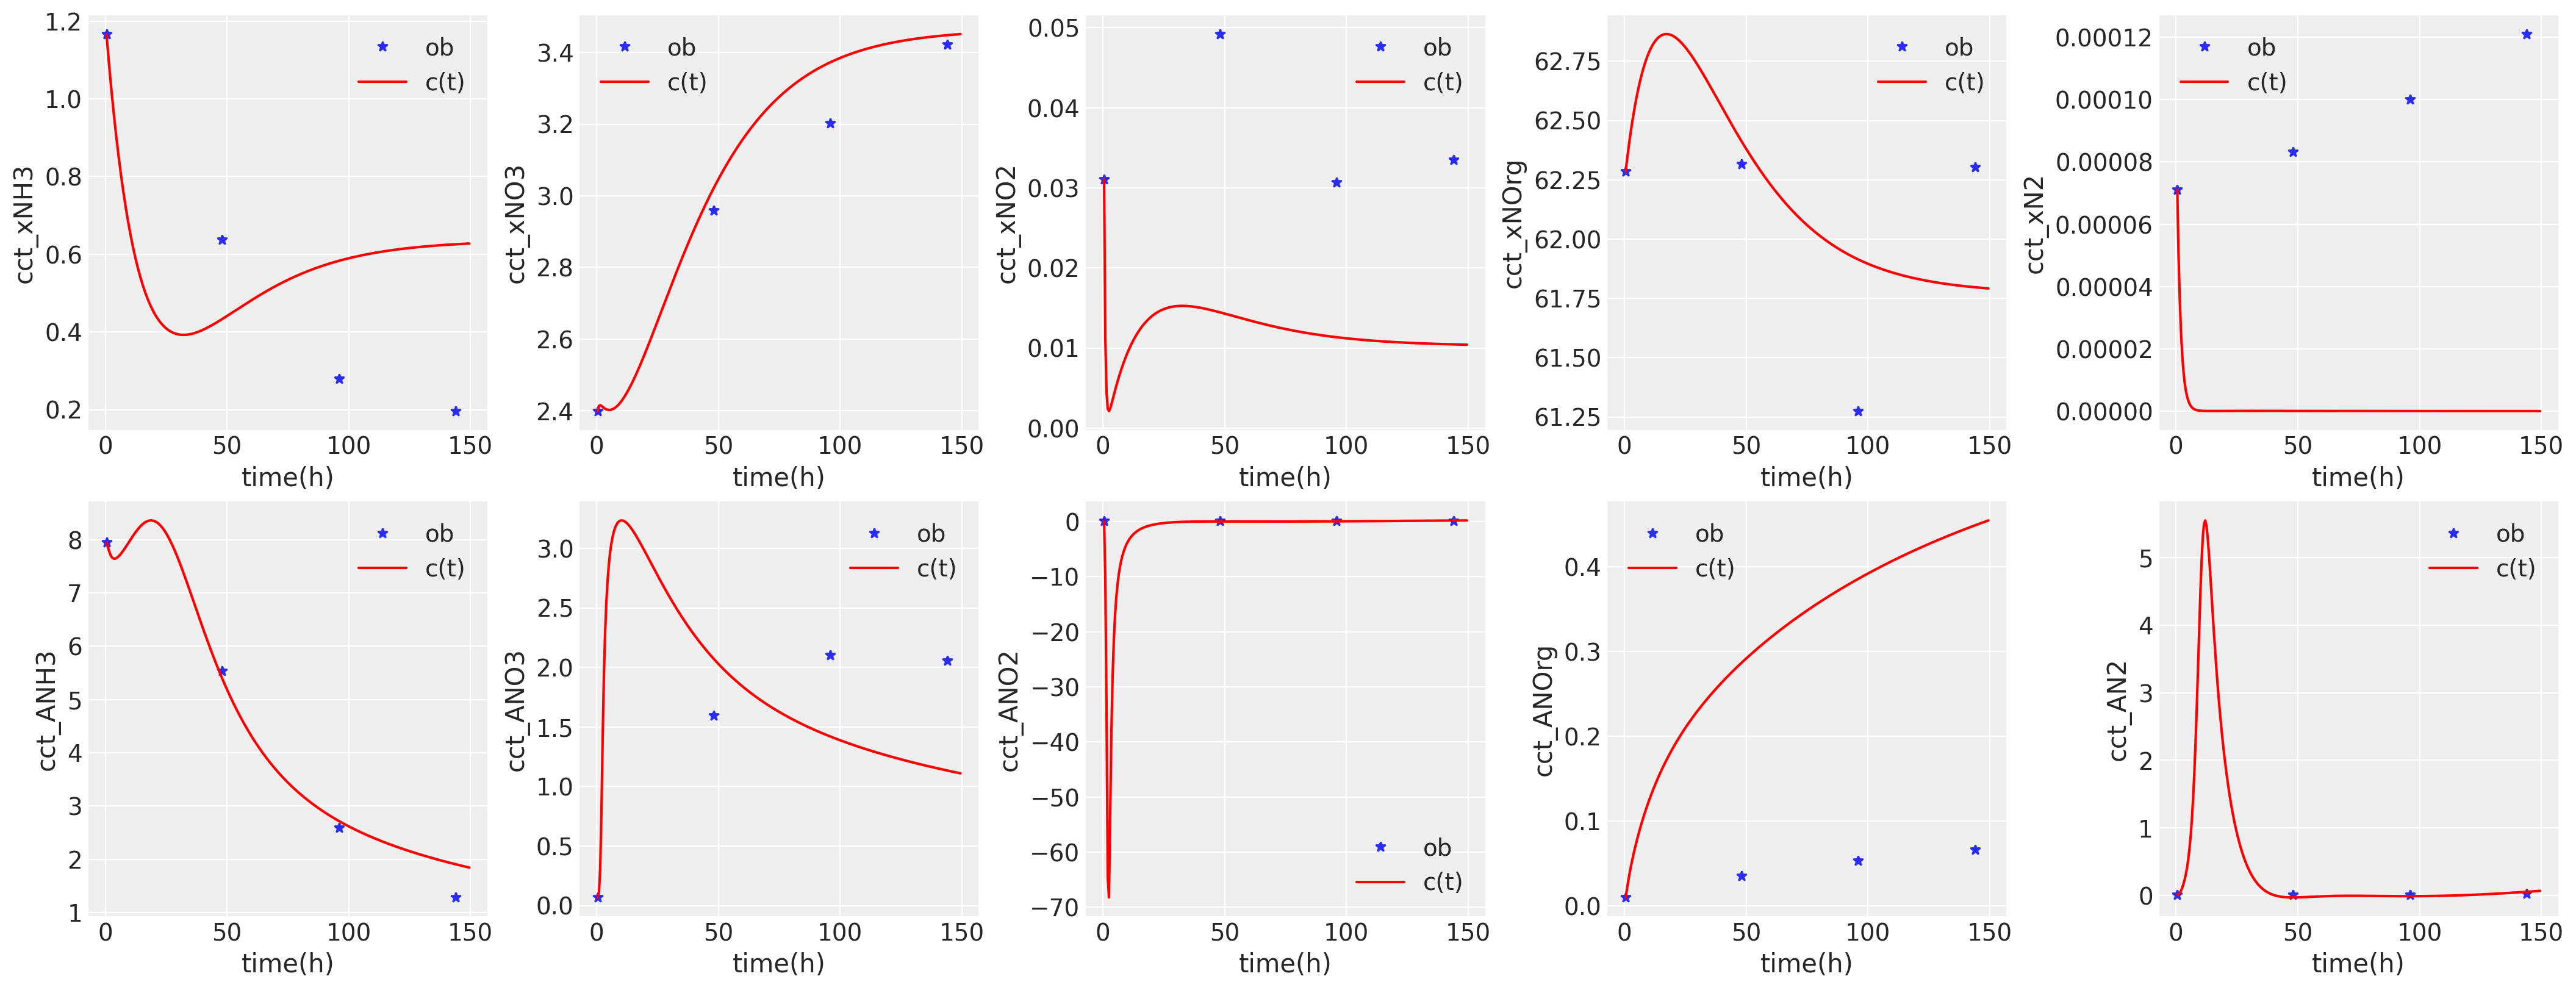

In [18]:
k_kinetics = [1,1,1,0,1,1,1,1,1,0,1]
t_eval = np.arange(0.5, 150, 0.5)
c0 = df[cct_names].iloc[0].values
ks_res, r2_trace = ltq_fit_rk(dataset, t_eval, c0, k_kinetics, maxfev=5000, plot_trace=False, show_process=True, pbar=None)


ks = ks_res
res = solve_ivp(dcdt_func, (t_eval.min(), t_eval.max()), c0, method='Radau', t_eval=t_eval, args=(ks, k_kinetics))
cs = res.y
t_eval = res.t

# res = odeint(func=dcdt_func2, y0=c0, t=t_eval, args=(ks,k_kinetics))
# cs = np.transpose(res, [1,0])

# 计算导数曲线
derivative = []
# 10*150
dcdt_df = pd.DataFrame(columns=['time'] + cct_names)

for i, t in enumerate(t_eval):
    cct = cs[:, i]
    dcdts = dcdt_func(t, cct, ks, k_kinetics)
    dcdt_df.loc[len(dcdt_df.index)] = [t] + dcdts

cols = 5
rows = math.ceil(len(cct_names) / cols)

fig, fig_axes = plt.subplots(ncols=cols, nrows=rows, figsize=(4.2 * cols, 4 * rows), dpi=100)
if isinstance(fig_axes, np.ndarray):
    fig_axes = fig_axes.reshape(-1)
else:
    fig_axes = [fig_axes]

for i, axes in enumerate(fig_axes):
    if i >= len(cct_names):
        axes.axis('off')
        continue

    y_name = cct_names[i]
    Y = df[y_name].values
    axes.plot(df['time'].values, Y, '*', label=f"ob")
    axes.set_ylabel(f'cct_{y_name}')
    axes.set_xlabel(f'time(h)')

    # axes.plot(df['time'].values, df[rates_names[i]].values, '+', label=f"rate")

    axes.plot(t_eval, cs[i, :], 'r', label=f"c(t)")
    # axes.plot(t_eval, dcdt_df[y_name].values,'g', label=f"c'(t)")

    axes.legend()
    # axes.set_title(f"{y_name}", fontsize=14)

plt.tight_layout()
plt.show()

